In [2]:
import nengo
import nengo.dists
from nengo.processes import WhiteSignal
import matplotlib.pyplot as plt
import numpy as np
from utils import get_w, get_conceptors

%matplotlib inline
%load_ext nengo.ipynb

<IPython.core.display.Javascript object>

In [3]:
n_neurons = 200
SEED = 0
encoders = nengo.dists.UniformHypersphere(surface=True).sample(200, 1)


with nengo.Network(seed=SEED) as train_model:
    in_nd = nengo.Node(WhiteSignal(10, high=5))
    ens = nengo.Ensemble(200, 1, neuron_type=nengo.LIFRate(), encoders=encoders)
    in_conn = nengo.Connection(in_nd, ens)
    
    p_target = nengo.Probe(in_nd)
    p_rates = nengo.Probe(ens.neurons)

In [4]:
with nengo.Simulator(train_model) as sim_train:
    sim_train.run(3)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


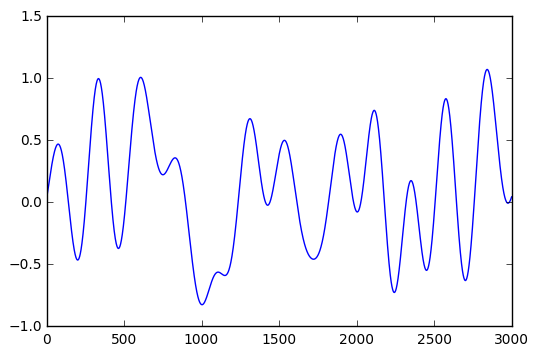

In [5]:
plt.plot(sim_train.data[p_target])

In [6]:
solver = nengo.solvers.LstsqL2(reg=0.02)
b_dec, _ = solver(sim_train.data[p_rates], sim_train.data[p_target])

In [7]:
r_dec = get_w(sim_train.data[p_rates].T, sim_train.data[p_target].T, n_neurons=n_neurons)

In [8]:
print(r_dec.shape)
print(b_dec.shape)

(200, 1)
(200, 1)


In [52]:
with nengo.Network(seed=SEED) as base_model:
    in_nd = nengo.Node(lambda t: np.sin(2*np.pi*t*5))
    ens = nengo.Ensemble(200, 1, neuron_type=nengo.LIFRate())
    nengo.Connection(in_nd, ens)
    
    p_ref = nengo.Probe(ens.neurons)
    p_out = nengo.Probe(ens, synapse=0.01)

In [53]:
with nengo.Simulator(base_model) as sim_base:
    sim_base.run(2)

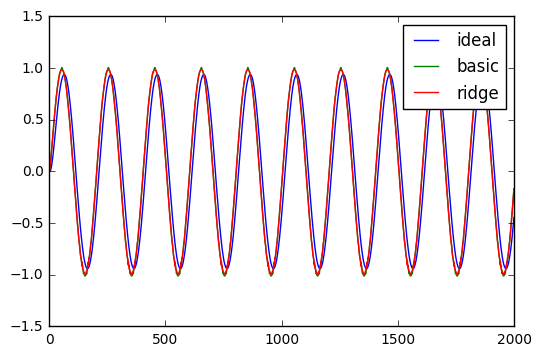

In [56]:
b_sig = np.dot(sim_base.data[p_ref], b_dec)
r_sig = np.dot(sim_base.data[p_ref], r_dec)
plt.plot(sim_base.data[p_out])
plt.plot(b_sig)
plt.plot(r_sig)
plt.legend(["ideal", "basic", "ridge"])

In [13]:
t_len = sim_train.trange().shape[0]
r_dat = sim_train.data[p_rates]
cc = get_conceptors([r_dat], 1, t_len, [10], n_neurons)

max correlation:99190.7377719
max sing vals:3019917.4173


In [14]:
print(cc[0].shape)
print(r_dat.shape)
print(np.dot(r_dat, cc[0].T).shape)

(200, 200)
(3000, 200)
(3000, 200)


In [15]:
silly_res = np.dot(np.dot(r_dat, cc[0].T), b_dec)

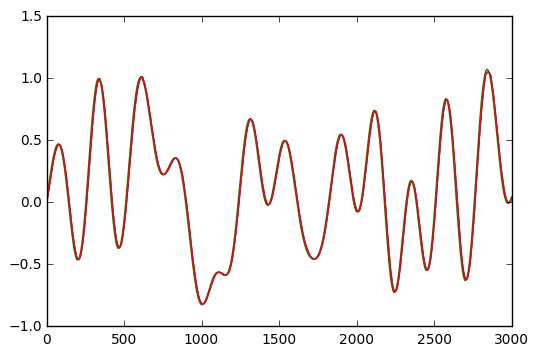

In [16]:
plt.plot(silly_res)
plt.plot(sim_train.data[p_target])
plt.plot(np.dot(r_dat, b_dec))

In [17]:
print(b_dec.shape)
print(encoders.shape)
alt_c = np.dot(b_dec, encoders.T)
print(alt_c.shape)
alt_silly = np.dot(np.dot(r_dat, alt_c), b_dec)

(200, 1)
(200, 1)
(200, 200)


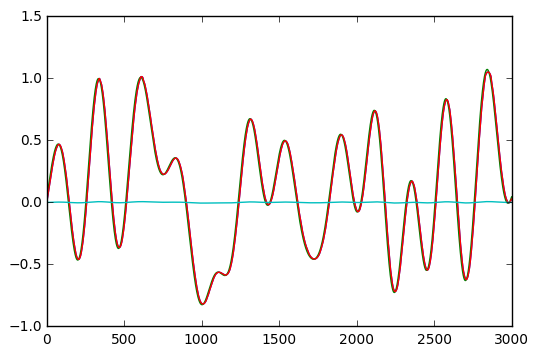

In [18]:
plt.plot(silly_res)
plt.plot(sim_train.data[p_target])
plt.plot(np.dot(r_dat, b_dec))
plt.plot(alt_silly)

In [19]:
print(r_dat.shape)
Y = sim_train.data[p_target]
print(Y.shape)
sigma = 1/10.0

(3000, 200)
(3000, 1)


In [20]:
svd_solve = nengo.utils.least_squares_solvers.SVD()
svd_silly = svd_solve(r_dat, Y, sigma)
print(svd_silly[0].shape)

(200, 1)


In [21]:
print(r_dat.shape)
svd_res = np.dot(np.dot(r_dat, svd_silly[0]), b_dec.T)
print(svd_res.shape)

(3000, 200)
(3000, 200)


In [22]:
print(np.dot(r_dat, svd_silly[0]).shape)

(3000, 1)


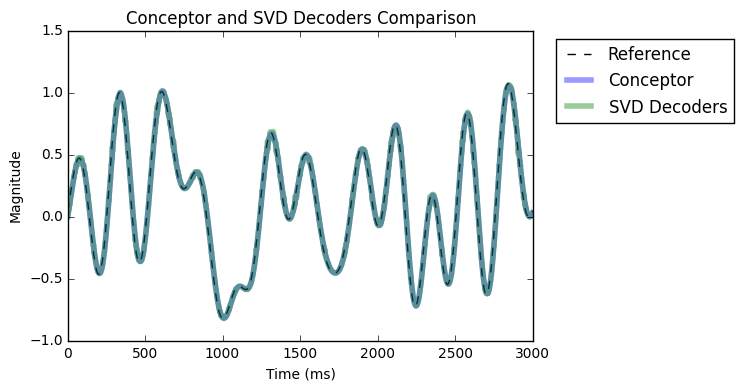

In [23]:
plt.plot(sim_train.data[p_target], color='black', linestyle='--')
plt.plot(silly_res, alpha=0.4, linewidth=4)
plt.plot(np.dot(r_dat, svd_silly[0]), alpha=0.4, linewidth=4)
plt.legend(["Reference", "Conceptor", "SVD Decoders"], bbox_to_anchor=(1.45, 1))
plt.xlabel("Time (ms)")
plt.ylabel("Magnitude")
plt.title("Conceptor and SVD Decoders Comparison")
plt.savefig("conc_svd_comp.pdf", format="pdf", bbox_inches="tight")

In [29]:
basic = np.dot(r_dat, svd_silly[0])
out_again = np.dot(np.dot(basic, encoders.T), b_dec)

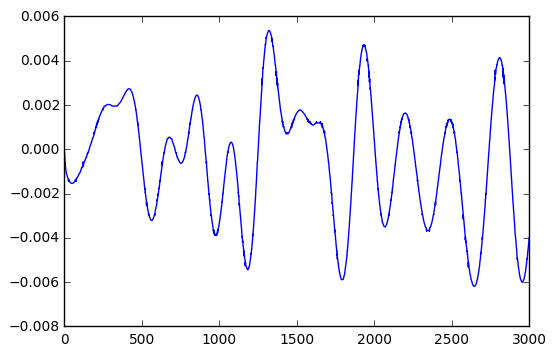

In [30]:
plt.plot(out_again)

In [33]:
import nengo.utils.numpy as npext

npext.rmse(cc[0].T, np.dot(svd_silly[0], encoders.T))

0.057770822733589494